## Import libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
sys.path.insert(1, '../')
from infer_pipeline import inferPipeline
from logger_ import make_logger
from datetime import datetime
from mlm_utils.transform_func import read_data, check_data_dir, get_files
from mlm_utils.metric_func import cosine_sim, cosine_module, ele_wise_sub

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-08-12 09:31:39.025736: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 09:31:39.805240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 09:31:42.582003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-12 09:31:45.250939: E tensorflow/compiler/xla/stream_executor/cuda/cu

In [2]:
def get_sum_avg(last_hidden_state, pos_tag_id):
    """Get word representation by sum and average of token embeddings

    Args:
        last_hidden_state (list): List of hidden states of each token
        pos_tag_id (list): vector pos_tag_id to get index of masked token

    Returns:
        batch of vector: batch of vector sum and average of token embeddings
    """
    b_sum_vector = []
    b_avg_vector = []
    
    for index in range(len(pos_tag_id)):
        masked_index = torch.where(pos_tag_id[index] != 0)
        sum_vector_present = torch.sum(last_hidden_state[index][masked_index], 0)
        avg_vector_present = torch.mean(last_hidden_state[index][masked_index], 0)
      
        assert sum_vector_present.shape == avg_vector_present.shape == torch.Size([768])
        
        b_sum_vector.append(sum_vector_present)
        b_avg_vector.append(avg_vector_present)
    return b_sum_vector, b_avg_vector

In [3]:
import torch.nn as nn

# def get_word_represent(model, dataloader):
#     '''Get word representation from original BioBert model
    
#     Args:
#         model (torch model): Original BioBert model
#         dataloader (torch dataloader): Dataloader to get batch of data
    
#     Returns:
#         df (pandas dataframe): Dataframe of word representation
#     '''
    
#     df = pd.DataFrame()
#     model.eval()
#     origin_ids = []
#     all_labels = []
#     all_predicts = []
#     all_logits = []
#     list_sum_vector = []
#     list_avg_vector = []
#     for batch in dataloader:
#         batch = tuple(t.to(device) if isinstance(t, torch.Tensor) else t for t in batch)
#         origin_uid, token_id, type_id, mask, label, pos_tag_id, _ = batch
#         origin_ids.append(origin_uid)
#         with torch.no_grad():
#             outputs_model = model(token_id, type_id, mask)
#             last_hidden_states = outputs_model[0]  # torch.Size([32, 85, 768])
#             logits = outputs_model[1]  # torch.Size([32, 85, 15])
#             predicted = torch.max(logits, dim=2)
#             sum_vector, avg_vector = get_sum_avg(last_hidden_states[0], pos_tag_id)
            
#             all_labels.append(label)
#             all_predicts.append(predicted[1])
#             all_logits.append(logits)
#             list_sum_vector.append(sum_vector)
#             list_avg_vector.append(avg_vector)
      
#     df['uid'] = [item.item() for sublist in origin_ids for item in sublist]
#     df['sum_vector'] = [item for sublist in list_sum_vector for item in sublist]
#     df['avg_vector'] = [item for sublist in list_avg_vector for item in sublist]
#     df['label'] = [item[:85] for sublist in all_labels for item in sublist]
#     df['predict'] = [item for sublist in all_predicts for item in sublist]
#     df['logits'] = [item for sublist in all_logits for item in sublist]
#     return df    
    
import torch
import pandas as pd

def get_word_represent(model, dataloader):
    '''Get word representation from original BioBert model
    
    Args:
        model (torch model): Original BioBert model
        dataloader (torch dataloader): Dataloader to get batch of data
    
    Returns:
        df (pandas dataframe): Dataframe of word representation
    '''
    
    model.eval()
    
    origin_ids = []
    all_labels = []
    all_predicts = []
    all_logits = []
    list_sum_vector = []
    list_avg_vector = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) if isinstance(t, torch.Tensor) else t for t in batch)
            origin_uid, token_id, type_id, mask, label, pos_tag_id, _ = batch
            origin_ids.extend(origin_uid)
            
            outputs_model = model(token_id, type_id, mask)
            last_hidden_states = outputs_model[0]  # torch.Size([32, 85, 768])
            logits = outputs_model[1]  # torch.Size([32, 85, 15])
            predicted = torch.argmax(logits, dim=2)
            sum_vector, avg_vector = get_sum_avg(last_hidden_states[0], pos_tag_id)
            
            all_labels.extend(label)
            all_predicts.extend(predicted)
            all_logits.extend(logits)
            list_sum_vector.extend(sum_vector)
            list_avg_vector.extend(avg_vector)
    
    df = pd.DataFrame({
        'uid': [item.item() for item in origin_ids],
        'sum_vector': list_sum_vector,
        'avg_vector': list_avg_vector,
        'label': [item[:85].tolist() for item in all_labels],
        'predict': [item.tolist() for item in all_predicts],
        'logits': [item.tolist() for item in all_logits]
    })
    
    return df
        

In [4]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn

# Load BioBERT model and tokenizer
biobert = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Define a new model with an additional FC layer
class BioBERTWithFC(nn.Module):
    def __init__(self, biobert, output_dim):
        super(BioBERTWithFC, self).__init__()
        self.biobert = biobert
        self.fc = nn.Linear(self.biobert.config.hidden_size, output_dim)
    
    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.biobert(input_ids=input_ids, token_type_ids = token_type_ids, attention_mask=attention_mask)
        logits = self.fc(outputs[0])
        return outputs, logits

# Define the number of labels
num_labels = 15
model = BioBERTWithFC(biobert, num_labels)


In [7]:
from pathlib import Path

# setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = 'get_word_represent', debugMode=True,
                    logFile=os.path.join(logDir, 'get_word_represent.log'), silent=True)
logger.info("logger created.")

# init pipeline for inference
pipe = inferPipeline(logger)

dataDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/perturbed_data/avg_pos_cos_module')
files = get_files(dataDir)
# pipe.infer(dataDir, files[0])

# df = get_word_represent(pipe.model, pipe.dataloader)
# df = get_word_represent(model, pipe.dataloader)
# df.head()

In [8]:
all_df = pd.DataFrame()
for file in files:
    logger.info(f"Processing file: {file}")
    pipe.infer(dataDir, file)
    df = get_word_represent(model, pipe.dataloader)
    all_df = pd.concat([all_df, df], ignore_index=True)
    

In [7]:
# Function to compare tensors and calculate average
def compare_tensors(row):
    label = torch.tensor(row['label'])
    predict = torch.tensor(row['predict'])
    comparison = torch.eq(label, predict)
    result = comparison.int()
    average = result.float().mean().item()  # Convert tensor to a Python float
    return average

# Apply the function to each row
df['comparison_result'] = df.apply(compare_tensors, axis=1)

df.head()

,uid,sum_vector,avg_vector,label,predict,logits,comparison_result
0,0,"[tensor(0.0303), tensor(-0.0741), tensor(0.111...","[tensor(0.0303), tensor(-0.0741), tensor(0.111...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[2, 4, 14, 14, 14, 14, 14, 2, 14, 2, 8, 8, 14,...","[[-0.01845479942858219, 0.16983799636363983, 0...",0.435294
1,0,"[tensor(-0.4892), tensor(-0.2317), tensor(-0.3...","[tensor(-0.4892), tensor(-0.2317), tensor(-0.3...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[2, 4, 14, 14, 14, 14, 2, 4, 14, 2, 14, 6, 14,...","[[0.023042531684041023, 0.18077470362186432, 0...",0.564706
2,0,"[tensor(1.5383), tensor(2.7585), tensor(-1.663...","[tensor(0.3846), tensor(0.6896), tensor(-0.415...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[2, 4, 14, 14, 14, 14, 14, 4, 4, 4, 8, 14, 8, ...","[[0.05688557028770447, 0.17035022377967834, 0....",0.517647
3,0,"[tensor(0.5839), tensor(1.3399), tensor(-0.764...","[tensor(0.2919), tensor(0.6700), tensor(-0.382...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[2, 4, 14, 4, 14, 14, 14, 4, 4, 4, 14, 14, 14,...","[[0.01617065817117691, 0.12041189521551132, 0....",0.541176
4,0,"[tensor(0.4258), tensor(-0.2785), tensor(-0.07...","[tensor(0.4258), tensor(-0.2785), tensor(-0.07...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[2, 4, 14, 14, 14, 14, 2, 4, 14, 4, 8, 14, 14,...","[[0.006145229563117027, 0.15574607253074646, 0...",0.458824


## compare the probability

In [8]:
import torch

def get_diff_prob(row):
    '''Get difference between probability of true label and predicted label'''
    logits = torch.tensor(row['logits'])
    labels = torch.tensor(row['label'])
    
    # Get the index of the maximum logit for each set of logits
    idx_max = torch.argmax(logits, dim=1)
    
    # Calculate the absolute differences in a vectorized manner
    diffs = torch.abs(logits[torch.arange(len(labels)), idx_max] - logits[torch.arange(len(labels)), labels])
    
    # Compute the average difference
    avg_diff = diffs.mean().item()
    
    return avg_diff


In [9]:
diff_prob = df.apply(get_diff_prob, axis=1)
diff_prob

0       0.205535
1       0.179017
2       0.187520
3       0.193468
4       0.203324
          ...   
1019    0.246493
1020    0.268214
1021    0.268012
1022    0.252067
1023    0.250836
Length: 1024, dtype: float64

## finetune model


In [10]:
model_path = '../model_path/multi_task_model_9_13050.pt'
pipe1 = inferPipeline(logger, model_path)

files = get_files(dataDir)
# pipe1.infer(dataDir, files[0])

# df1 = get_word_represent(pipe1.model.network, pipe1.dataloader)
# df1.head()

In [11]:
all_df2 = pd.DataFrame()
for file in files:
    logger.info(f"Processing file: {file}")
    pipe1.infer(dataDir, file)
    df1 = get_word_represent(pipe1.model.network, pipe1.dataloader)
    all_df2 = pd.concat([all_df2, df1], ignore_index=True)

,uid,sum_vector,avg_vector,label,predict,logits
0,0,"[tensor(0.1724), tensor(1.1689), tensor(0.2634...","[tensor(0.1724), tensor(1.1689), tensor(0.2634...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 10, 14, 14, 14, 14, 1, 1, 1, 1, 1, 14,...","[[-2.1991045475006104, -2.7089333534240723, -3..."
1,0,"[tensor(-0.0733), tensor(0.4202), tensor(-0.48...","[tensor(-0.0733), tensor(0.4202), tensor(-0.48...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 2, 14, 14, 14, 14, 14, 1, 1, 0, 1, 14,...","[[-1.6983191967010498, -2.5478873252868652, -3..."
2,0,"[tensor(1.8812), tensor(2.8069), tensor(-0.184...","[tensor(0.4703), tensor(0.7017), tensor(-0.046...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 1, 14, 14, 14, 14, 14, 1, 1, 1, 1, 5, ...","[[-1.7608840465545654, -1.0890522003173828, -3..."
3,0,"[tensor(-0.7623), tensor(0.8623), tensor(-1.49...","[tensor(-0.3812), tensor(0.4312), tensor(-0.74...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 2, 2, 14, 14, 14, 14, 14, 1, 1, 1, 1, 14,...","[[-1.2474126815795898, -3.112067699432373, -3...."
4,0,"[tensor(-0.1963), tensor(0.7850), tensor(-0.43...","[tensor(-0.1963), tensor(0.7850), tensor(-0.43...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 1, 14, 14, 14, 14, 14, 1, 1, 1, 1, 14,...","[[-2.685140609741211, -1.6147021055221558, -2...."


In [12]:
# Apply the function to each row
df1['comparison_result'] = df1.apply(compare_tensors, axis=1)
df1.head()


,uid,sum_vector,avg_vector,label,predict,logits,comparison_result
0,0,"[tensor(0.1724), tensor(1.1689), tensor(0.2634...","[tensor(0.1724), tensor(1.1689), tensor(0.2634...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 10, 14, 14, 14, 14, 1, 1, 1, 1, 1, 14,...","[[-2.1991045475006104, -2.7089333534240723, -3...",0.729412
1,0,"[tensor(-0.0733), tensor(0.4202), tensor(-0.48...","[tensor(-0.0733), tensor(0.4202), tensor(-0.48...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 2, 14, 14, 14, 14, 14, 1, 1, 0, 1, 14,...","[[-1.6983191967010498, -2.5478873252868652, -3...",0.658824
2,0,"[tensor(1.8812), tensor(2.8069), tensor(-0.184...","[tensor(0.4703), tensor(0.7017), tensor(-0.046...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 1, 14, 14, 14, 14, 14, 1, 1, 1, 1, 5, ...","[[-1.7608840465545654, -1.0890522003173828, -3...",0.600000
3,0,"[tensor(-0.7623), tensor(0.8623), tensor(-1.49...","[tensor(-0.3812), tensor(0.4312), tensor(-0.74...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 2, 2, 14, 14, 14, 14, 14, 1, 1, 1, 1, 14,...","[[-1.2474126815795898, -3.112067699432373, -3....",0.658824
4,0,"[tensor(-0.1963), tensor(0.7850), tensor(-0.43...","[tensor(-0.1963), tensor(0.7850), tensor(-0.43...","[12, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, ...","[12, 0, 1, 14, 14, 14, 14, 14, 1, 1, 1, 1, 14,...","[[-2.685140609741211, -1.6147021055221558, -2....",0.447059


In [13]:
diff_prob2 = df1.apply(get_diff_prob, axis=1)
diff_prob2 

0       1.963153
1       2.128516
2       2.712454
3       2.968711
4       3.358857
          ...   
1019    0.991864
1020    2.452173
1021    1.651917
1022    0.987961
1023    0.985987
Length: 1024, dtype: float64

In [14]:
diff_acc = abs(df1['comparison_result'] - df['comparison_result'])


In [15]:
diff_probability = abs(diff_prob2 - diff_prob)

In [16]:
combine_diff = (diff_acc + diff_probability) / 2

In [17]:
df['sum_vector'] = df['sum_vector'].apply(lambda x: x.tolist())
df1['sum_vector'] = df1['sum_vector'].apply(lambda x: x.tolist())
cos = pd.Series(map(cosine_sim, df['sum_vector'], df1['sum_vector']))
cosmo = pd.Series(map(cosine_module, df['sum_vector'], df1['sum_vector'], cos))

ele_wise = pd.Series(map(lambda x, y: ele_wise_sub(x, y, negate=True), df['sum_vector'], df1['sum_vector']))


cos_diff = 1 - np.abs(cos)
cos_mo_diff = 1 - np.abs(cosmo)
ele_sub = pd.Series(map(lambda x, y: ele_wise_sub(x, y), df['sum_vector'], df1['sum_vector']))

In [18]:
len(diff_acc)

1024

In [15]:
# caculate cosine similarity between two vectors, which is all the pair items in sum_vector columns

# embDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/word_represent_finetuned_model')
# emb_files = get_files(embDir)

# emb_df = pd.DataFrame(read_data(embDir/emb_files[0]))

# # Rename the columns
# emb_df = emb_df.rename(columns={'origin_uid': 'uid'})

In [19]:
score = pd.read_csv('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/perturbed_data/importance_score/file/importance_score_avg_pos_cos_module/pair_score_abolish.csv', sep='\t')
score.head()

,uid,influence,relevance,brier_score
0,0,0.30092,-0.13173,0.89445
1,0,0.43736,-0.05491,0.89445
2,0,0.41479,-0.10286,0.89445
3,0,0.60422,0.03967,0.89445
4,0,0.05833,0.12234,0.89445


In [20]:
score.shape

(1024, 4)

In [23]:
# calculate pearson correlation between influence and relevance
for i in score.columns:
    print(i, diff_acc.corr(score[i], method='pearson'))
    print(i, diff_probability.corr(score[i], method='pearson'))
    print(i, combine_diff.corr(score[i], method='pearson'))
    print(i, cos.corr(score[i], method='pearson'))
    print(i, cosmo.corr(score[i], method='pearson'))
    print(i, ele_wise.corr(score[i], method='pearson'))
    print("================================")
    

uid 0.06303911506585962
uid -0.09727892791628409
uid -0.09288138739097544
uid 0.033485670180680396
uid 0.033842777726237415
uid -0.043876912467154985
influence -0.2955306680543032
influence 0.4571663392962283
influence 0.4365919862382238
influence -0.03344816367305267
influence -0.03164511485128347
influence -0.3562664737278471
relevance -0.2862862081277361
relevance 0.24819233294240248
relevance 0.2210248051154106
relevance -0.032500647412537484
relevance -0.033149550541164176
relevance -0.22654020116923687
brier_score 0.14840936352943904
brier_score -0.47968346144947266
brier_score -0.4786487746965512
brier_score -0.08594270278807334
brier_score -0.08402522676665387
brier_score 0.01342796862535813


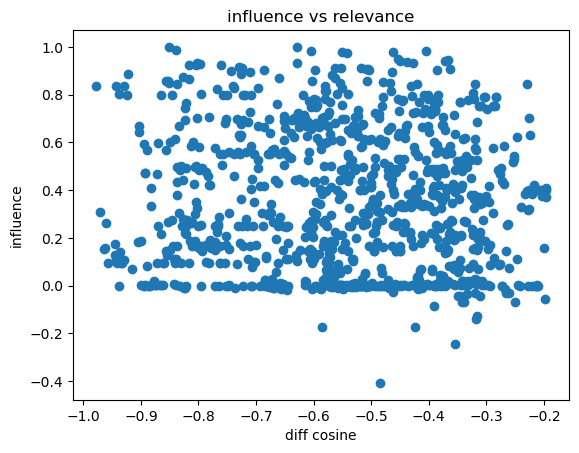

In [37]:
# visualize the correlation between influence and relevance
import matplotlib.pyplot as plt
plt.scatter(diff_cos, score['influence'])
plt.xlabel('diff cosine')
plt.ylabel('influence')
plt.title('influence vs relevance')
plt.show()


In [56]:
def cal_similarity(pipe, dataDir, embDir, wriDir):
    """Calculate similarity between word representation of original BioBert and word representation of fine-tuned BioBert.

    Args:
        pipe (InferPipeline): InferPipeline object
        dataDir (str): Directory of word representation of original BioBert
        embDir (str): Directory of word representation of fine-tuned BioBert
        wriDir (str): Directory to write similarity result

    Returns:
        DataFrame: DataFrame of similarity result for two hypothesises
    """
    
    files = get_files(dataDir)
    emb_files = get_files(embDir)
    
    check_data_dir(wriDir, auto_create=True)
    
    for file, emb_file in tqdm(zip(files, emb_files)):
        print("file", file, "emb_file", emb_file)
        df_metric = pd.DataFrame()
    
        pipe.infer(dataDir, file)
        df = get_word_represent(pipe.model, pipe.dataloader)
    
        emb_df = pd.DataFrame(read_data(embDir/emb_file))
       
        # convert tensor to list
        df['sum_vector'] = df['sum_vector'].apply(lambda x: x.tolist())
        
        # calculate Hypothesis 1 and Hypothesis 2 
        df_metric['uid'] = df['uid']
        df_metric['cos_sim'] = pd.Series(map(cosine_sim, df['sum_vector'], emb_df['sum_vector']))
        df_metric['cos_mo'] = pd.Series(map(cosine_module, df['sum_vector'], emb_df['sum_vector'], df_metric['cos_sim']))
        df_metric['ele_sub_neg'] = pd.Series(map(lambda x, y: ele_wise_sub(x, y, negate=True), df['sum_vector'], emb_df['sum_vector']))
        
        df_metric['cos_dif'] = 1 - np.abs(df_metric['cos_sim'])
        df_metric['cos_mo_dif'] = 1 - np.abs(df_metric['cos_mo'])
        df_metric['ele_sub'] = pd.Series(map(lambda x, y: ele_wise_sub(x, y), df['sum_vector'], emb_df['sum_vector']))
        
        # save df to csv 
        df_metric.to_csv(wriDir/f'{file}.csv'.replace('.json', ''), index=False)
        
        print(f'{file} done')
    return df_metric
    

In [57]:
# setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = 'get_word_represent', debugMode=True,
                    logFile=os.path.join(logDir, 'get_word_represent.log'), silent=True)
logger.info("logger created.")

# init pipeline for inference
pipe = inferPipeline(logger)


## PAS estimation

In [ ]:
from pathlib import Path
dataDir = Path('./data_mlm/process_folder/mlm_output')
wriDir = Path('./data_mlm/process_folder/PAS_knowledge')
embDir = Path('./data_mlm/process_folder/word_represent_finetuned_model')
df = cal_similarity(pipe, dataDir, embDir, wriDir)                                 


## Correlation between PAS knowledge and importance score of features

In [4]:
import pandas as pd
import os
from datetime import datetime
from mlm_utils.transform_func import get_files
from metrics_calculation import get_importance_score, evaluateWord
from data_maker import DataMaker
from infer_pipeline import inferPipeline
from logger_ import make_logger

In [ ]:
dataMaskedDir = './data_mlm/perturbed_data/avg_pos_cos_module/'
dataOriginDir = './data_mlm/process_folder/coNLL_tsv_json/ner_json/'
model_path = '../model_path/multi_task_model_9_13050.pt'


# setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = 'test_corr_inf_lhs', debugMode=True,
                    logFile=os.path.join(logDir, '{}.log'.format('test_corr_inf_lhs')), silent=True)
logger.info("logger created.")

pipe = inferPipeline(logger, model_path)
labelMap = pipe.taskParams.labelMap['conllsrl']
labelRn = {v:k for k,v in labelMap.items()}
 
file_mask = sorted(get_files(dataMaskedDir))
file_origin = sorted(get_files(dataOriginDir))
all_pair_score = []

for mask, origin in zip(file_mask, file_origin):   
    resultwordMasked = evaluateWord(dataMaskedDir, mask, pipe.model, labelRn, hasTrueLabels=False, needMetrics=False, is_mask_token=False, del_mask_token=False)
    resultOrigin = evaluateWord(dataOriginDir, origin, pipe.model, labelRn, hasTrueLabels=True, needMetrics=False)

    # labelMap = {v: k for k, v in labelRn.items()}
    score_dict, list_pair_score = get_importance_score(resultOrigin, resultwordMasked, labelMap)
    all_pair_score.extend(list_pair_score)

In [ ]:
# read csv 
score = './data_mlm/perturbed_data/importance_score_avg_pos_cos_module/'
pas_inf = './data_mlm/process_folder/PAS_knowledge/' 
files = get_files(score)
pas_files = get_files(pas_inf)
all_cosine = pd.DataFrame()
all_pas = pd.DataFrame()

# merge all csv file to dataframe 
for file, pas_file in zip(files, pas_files):
   
    cos = pd.read_csv(os.path.join(score, file), sep='\t')
    all_cosine = pd.concat([all_cosine, cos], axis=0, ignore_index = True)
    
    pas = pd.read_csv(os.path.join(pas_inf, pas_file))
    all_pas = pd.concat([all_pas, pas], axis=0, ignore_index = True)
    
    # drop nan
    all_cosine = all_cosine.dropna()
    all_pas = all_pas.dropna()
    

In [ ]:
all_cosine.shape

(83232, 4)

In [ ]:
all_pas.shape

(83232, 7)

In [ ]:
import numpy as np
from scipy.stats import spearmanr
for col in all_pas.columns[1:]:
    correlation_coefficient, p_value = spearmanr(all_cosine['relevance'], all_pas[col])
    print(col, correlation_coefficient, p_value)
    

cos_sim 0.0333776226794917 5.859596965062307e-22
cos_mo 0.02772554275937736 1.2419232070246777e-15
ele_sub_neg -0.25551198117750207 0.0
cos_dif -0.0033978376573552387 0.32695641269095943
cos_mo_dif -0.021068825025361382 1.2098693531844976e-09
ele_sub 0.25551198117750207 0.0


In [ ]:
pas_inf = './data_mlm/process_folder/PAS_knowledge/' 

pas_files = get_files(pas_inf)
all_pas = pd.DataFrame()
all_avg = pd.DataFrame()
for file in pas_files:
   
    pas = pd.read_csv(os.path.join(pas_inf, file))
    pas = pas.dropna()
    
    # get average of each columns
    avg = pas.mean(axis=0)
    avg = avg.to_frame().T
    avg['file'] = file.replace('mlm_', '').replace('_full.csv', '')
    all_avg = pd.concat([all_avg, avg], axis=0, ignore_index = True)
    

In [ ]:
all_avg.head()

,cos_sim,cos_mo,ele_sub_neg,cos_dif,cos_mo_dif,ele_sub,file
0,-0.006991,-0.005728,-1.022529,0.975287,0.978200,1.022529,abolish
1,-0.012353,-0.010508,-0.942612,0.973449,0.976715,0.942612,alter
2,-0.027731,-0.023953,-0.850819,0.964781,0.969429,0.850819,begin_1
3,-0.009171,-0.007692,-0.878912,0.976034,0.979272,0.878912,begin_2
4,-0.016837,-0.014419,-1.191545,0.978128,0.981188,1.191545,block


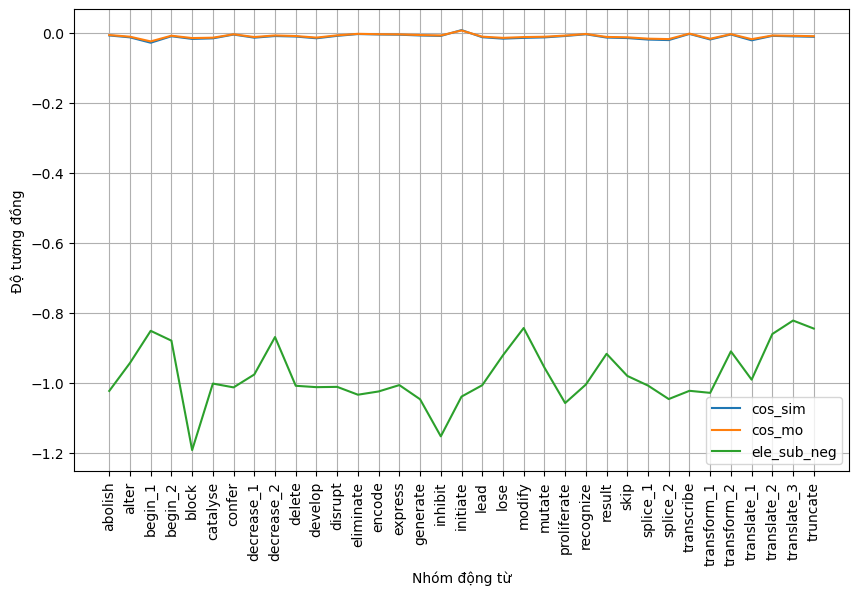

In [ ]:
# visualize 3 first columns of all_avg using scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

# using multiline plot
plt.figure(figsize=(10, 6))
plt.xlabel('Nhóm động từ')
plt.ylabel('Độ tương đồng')
sns.lineplot(data=all_avg, x='file', y='cos_sim', label='cos_sim')
sns.lineplot(data=all_avg, x='file', y='cos_mo', label='cos_mo')
sns.lineplot(data=all_avg, x='file', y='ele_sub_neg', label='ele_sub_neg')
plt.xticks(rotation=90)
plt.grid()
plt.show()
